It makes sense that different females value attributes differently. Some might but more weight on looks while others more on intelligence. Why aggregate their differernt weights in 1 model? Just like we split up males and females, we will split up females using K-means clustering. We will cluster on the self assessment dataset and then map these clusters on to the scores datset.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.chdir('/Users/wynnephilpott/Documents/missing pauldron/Data Science/datasets')

In [8]:
df = pd.read_csv('dfd.csv') 

In [9]:
df.shape

(524, 52)

In [10]:
female = df[df['gender']==0]

In [11]:
female.columns

Index(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date',
       'go_out', 'career_c', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'exphappy', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
       'shar1_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1',
       'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1'],
      dtype='object')

In [12]:
f = female.drop(['id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position'],axis=1)

In [13]:
from sklearn.cluster import KMeans

In [14]:
#choose k value
ssd = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(f)
    ssd.append(km.inertia_)

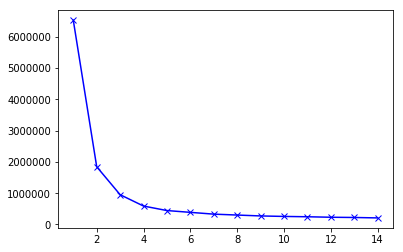

In [15]:
plt.plot(K,ssd,'bx-')

Within-cluster variation stops "improving" dramatically at 3 so we will use 3 clusters.

In [16]:
km = KMeans(n_clusters=3)
km.fit(f.drop('iid',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
km.labels_[1:25] #female 1 is in cluster 1, female 2 in cluster 0....

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1, 0,
       2, 1], dtype=int32)

In [18]:
kmf = pd.Series(km.labels_) #array to series 
kmf = kmf.to_frame(name='cluster') #series to dataframe

In [19]:
iid_kmf = pd.concat([female['iid'].reset_index(drop=True),kmf],axis=1) #combine the iids and the cluster they are in

In [20]:
iid_kmf.head()

,iid,cluster
0,4,0
1,5,1
2,6,0
3,7,0
4,8,0


In [21]:
score = pd.read_csv('dfs.csv')
female_score = score[score['gender']==0]

In [22]:
dff = pd.merge(iid_kmf,female_score,on='iid',how='inner') #map the clusters onto the score dataframe

In [23]:
dff.head()

,iid,cluster,gender,order,partner,pid,match,int_corr,samerace,age_o,...,met_o,dec,attr,sinc,intel,fun,amb,like,prob,met
0,4,0,0,3,1,11,0,-0.18,1,27,...,2,0,4.0,10.0,8.0,5.0,8.0,6.0,7.0,2
1,4,0,0,2,2,12,0,-0.18,1,22,...,1,0,8.0,7.0,8.0,10.0,7.0,8.0,1.0,1
2,4,0,0,4,4,14,1,-0.18,1,23,...,1,1,8.0,10.0,7.0,10.0,7.0,8.0,10.0,1
3,4,0,0,6,5,15,0,0.21,0,24,...,2,0,6.0,9.0,8.0,9.0,8.0,7.0,7.0,2
4,4,0,0,5,6,16,0,0.37,1,25,...,2,0,5.0,10.0,8.0,4.0,8.0,4.0,3.0,2


In [24]:
dff['cluster'].value_counts()

0    1843
1    1039
2     217
Name: cluster, dtype: int64

**LGM**

In [25]:
df = dff

In [33]:
cluster1 = df[df['cluster']==0]
cluster2 = df[df['cluster']==1]
cluster3 = df[df['cluster']==2]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression

In [35]:
lgm = LogisticRegression()

Cluster 1

In [36]:
X = cluster1[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster1['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       327
           1       0.75      0.68      0.71       226

   micro avg       0.77      0.77      0.77       553
   macro avg       0.77      0.76      0.76       553
weighted avg       0.77      0.77      0.77       553

[[275  52]
 [ 73 153]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets look at the weight/size of the coefficients which we can more or less use to discern how much they impact the model.

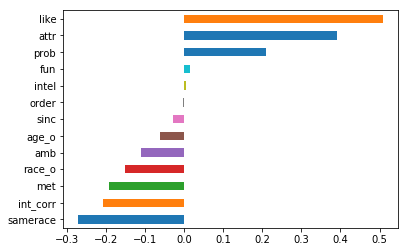

In [30]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

**Customize the Model**

Lets drop X's that do not have a huge impact on our dependent variable.

In [37]:
X = cluster1[['int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'amb', 'like', 'prob', 'met']]
y = cluster1['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       327
           1       0.75      0.68      0.71       226

   micro avg       0.78      0.78      0.78       553
   macro avg       0.77      0.76      0.76       553
weighted avg       0.77      0.78      0.77       553

[[276  51]
 [ 73 153]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We gained 1 true negative.

Cluster 2

In [38]:
X = cluster2[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster2['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       186
           1       0.64      0.67      0.66       126

   micro avg       0.72      0.72      0.72       312
   macro avg       0.71      0.71      0.71       312
weighted avg       0.72      0.72      0.72       312

[[139  47]
 [ 41  85]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets try customizing this model.

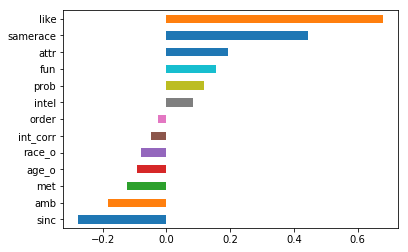

In [39]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

Again, remove those variables with small coefficients.

In [40]:
X = cluster2[['samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster2['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       186
           1       0.66      0.68      0.67       126

   micro avg       0.73      0.73      0.73       312
   macro avg       0.72      0.72      0.72       312
weighted avg       0.73      0.73      0.73       312

[[141  45]
 [ 40  86]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 went up.

Cluster 3

In [43]:
X = cluster3[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster3['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81        41
           1       0.82      0.36      0.50        25

   micro avg       0.73      0.73      0.73        66
   macro avg       0.76      0.66      0.66        66
weighted avg       0.75      0.73      0.69        66

[[39  2]
 [16  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


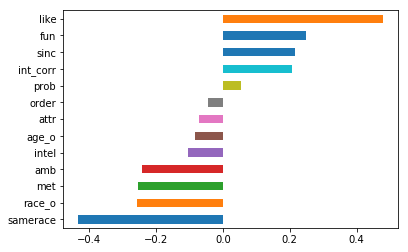

In [44]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

In [46]:
X = cluster3[['int_corr', 'order',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'met']]
y = cluster3['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80        41
           1       0.75      0.36      0.49        25

   micro avg       0.71      0.71      0.71        66
   macro avg       0.73      0.64      0.64        66
weighted avg       0.72      0.71      0.68        66

[[38  3]
 [16  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Dropping fields does not seem to work with this sample size.

Overall 248 'yes's were classified correctly compared to the 203 from LGM alone.